In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler

from scipy.sparse import issparse
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [24]:
data = pd.read_csv("./Data/payload_full.csv")
data.head()

,payload,length,attack_type,label
0,c/ caridad s/n,14,norm,norm
1,"campello, el",12,norm,norm
2,40184,5,norm,norm
3,1442431887503330,16,norm,norm
4,nue37,5,norm,norm


In [25]:
# # Đếm số lượng các giá trị trong cột 'label'
# label_counts = data['attack_type'].value_counts()

# # Màu sắc cho từng nhãn
# colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

# # Nhãn cho từng phần
# labels = label_counts.index

# # Tính phần trăm cho từng nhãn
# percentages = [f'{(count / label_counts.sum() * 100):.2f}%' for count in label_counts]

# # Kết hợp nhãn với phần trăm
# legend_labels = [f'{label} ({percentage})' for label, percentage in zip(labels, percentages)]

# # Vẽ biểu đồ tròn với chú thích nhưng không có nhãn trên các phần
# fig, ax = plt.subplots()
# wedges, texts = ax.pie(label_counts, 
#                        colors=colors, 
#                        startangle=90, 
#                        counterclock=False,
#                        autopct=None)

# # Chú thích
# ax.legend(wedges, legend_labels, title="Labels", loc="upper right", bbox_to_anchor=(1, 0, 0.5, 1))

# # Tiêu đề biểu đồ
# plt.title("Tỷ lệ phần trăm các nhãn trong cột label")
# plt.axis('equal')  # Đảm bảo hình tròn không bị méo
# plt.show()

In [26]:
# # Đếm số lượng các giá trị trong cột 'label'
# label_counts = data['label'].value_counts()

# # Vẽ biểu đồ tròn
# plt.figure(figsize=(5, 5))
# plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])

# # Thêm tiêu đề
# plt.title('Tỷ lệ phần trăm các nhãn trong cột label')

# # Đảm bảo biểu đồ có hình tròn
# plt.axis('equal')

# # Hiển thị biểu đồ
# plt.show()

In [27]:
# Chuyển đổi dữ liệu thành mảng
train_data = data["payload"].values
label_data = data["label"].values
X_train, X_test, y_train, y_test = train_test_split(train_data, label_data, test_size=0.2, random_state=42)
print(data["payload"].values, data["label"].values)

['c/ caridad s/n' 'campello, el' '40184' ...
 '<script "a=\'>\'" id=xss src="http://ha.ckers.org/xss.js"></script>'
 '<script a=`>` id=xss src="http://ha.ckers.org/xss.js"></script>'
 '<script>document.write("<scri");</script>pt id=xss src="http://ha.ckers.org/xss.js"></script>'] ['norm' 'norm' 'norm' ... 'anom' 'anom' 'anom']


In [28]:
print(train_data.shape)

(31067,)


In [29]:
label_binarizer = LabelBinarizer()
y_test_binary = label_binarizer.fit_transform(y_test)
y_train_binary = label_binarizer.fit_transform(y_train)

In [30]:
print(y_test_binary[0])
print(y_test[0])

[1]
norm


In [31]:
from sklearn.preprocessing import LabelEncoder
train_data = data["payload"].values
label_data = data["attack_type"].values
X_train, X_test, y_train, y_test = train_test_split(train_data, label_data, test_size=0.2, random_state=42)

In [32]:
y_train

array(['sqli', 'norm', 'norm', ..., 'norm', 'sqli', 'norm'], dtype=object)

In [33]:
label_encode = LabelEncoder()
y_test_encode = label_encode.fit_transform(y_test)
y_train_encode = label_encode.transform(y_train)

In [34]:
print(np.unique(y_train), np.unique(y_train_encode))


['cmdi' 'norm' 'path-traversal' 'sqli' 'xss'] [0 1 2 3 4]


In [35]:
X_train.shape

(24853,)

# Visualization

## Before SMOTE

In [36]:
unique_bfsmote, counts_bfsmot = np.unique(y_train_encode, return_counts=True)

In [37]:
counts_bfsmot

array([   71, 15429,   225,  8699,   429], dtype=int64)

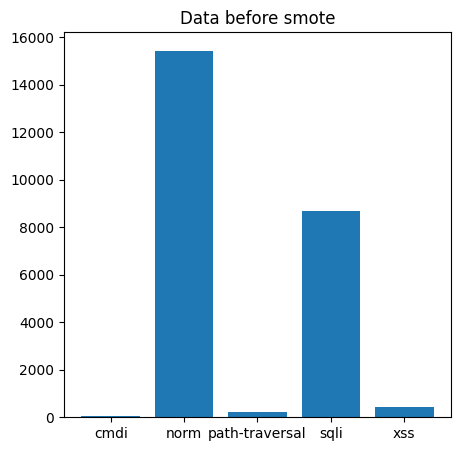

In [38]:
plt.figure(figsize = (5,5))
plt.bar(np.unique(y_train), counts_bfsmot)
plt.title("Data before smote")
plt.show()

## After SMOTE

In [39]:
vectorizer = TfidfVectorizer(min_df=0.0, analyzer="char", sublinear_tf=True, ngram_range=(3, 3), max_features=8000)
tfidf_matrix = vectorizer.fit_transform(X_train)
smt = SMOTE()
reduced_data, label_train = smt.fit_resample(tfidf_matrix, y_train_encode)

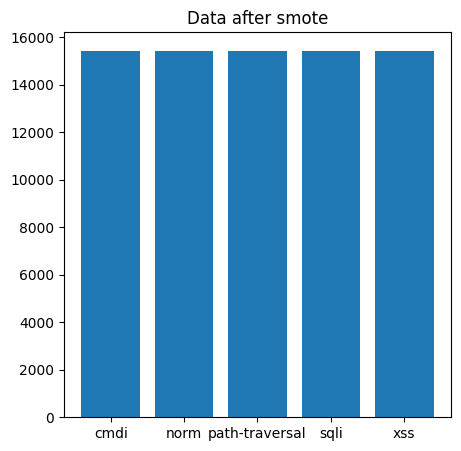

In [40]:
unique_atsmote, counts_atsmot = np.unique(label_train, return_counts=True)
plt.figure(figsize = (5,5))
plt.bar(np.unique(y_train), counts_atsmot)
plt.title("Data after smote")
plt.show()

# Train

In [41]:
reduced_data.shape

(77145, 8000)

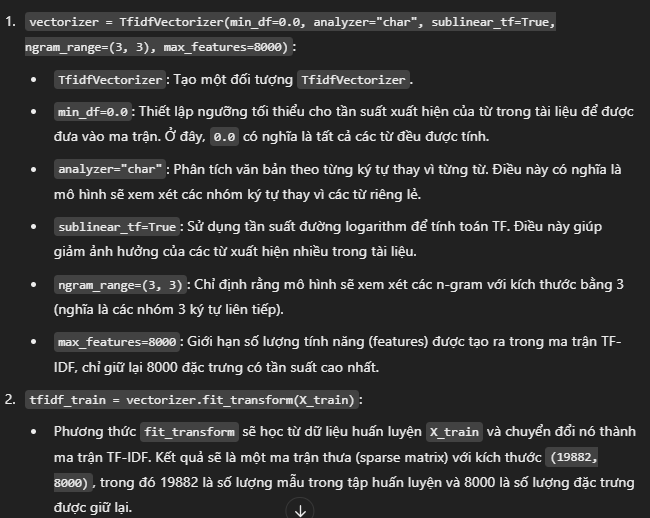
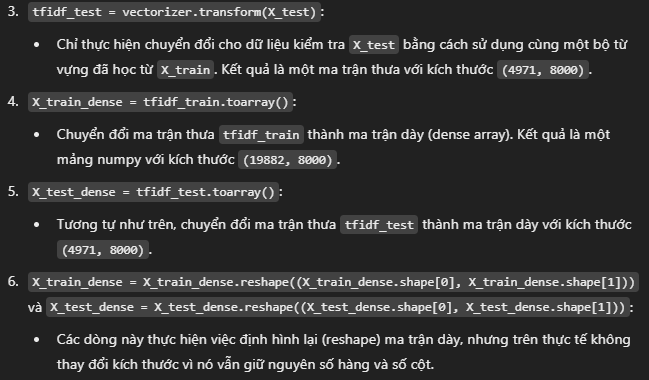

In [42]:
vectorizer = TfidfVectorizer(min_df=0.0, analyzer="char", sublinear_tf=True, ngram_range=(3, 3), max_features=8000)
# Transform the training data into a TF-IDF matrix
tfidf_train = vectorizer.fit_transform(X_train)  # (19882, 8000) sparse matrix
tfidf_test = vectorizer.transform(X_test)  # (4971, 8000) sparse matrix

# Convert sparse matrices to dense
X_train_dense = tfidf_train.toarray()  # (19882, 8000)
X_test_dense = tfidf_test.toarray()  # (4971, 8000)

X_train_dense = X_train_dense.reshape((X_train_dense.shape[0],X_train_dense.shape[1]))
X_test_dense = X_test_dense.reshape((X_test_dense.shape[0], X_test_dense.shape[1]))


In [43]:
y_train_encode.shape

(24853,)

In [45]:
# import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
label_encode = LabelEncoder()
y_test_encode = label_encode.fit_transform(y_test)
y_train_encode = label_encode.transform(y_train)
# One-hot encoding for multi-class classification
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_encode = one_hot_encoder.fit_transform(y_train_encode.reshape(-1, 1))
y_test_encode = one_hot_encoder.transform(y_test_encode.reshape(-1, 1))
model = Sequential()
model.add(Dense(128, activation='softmax'))

model.add(Dense(16, activation='softmax'))

# Output layer (binary classification)
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train_encode, epochs=10, batch_size=32)

Epoch 1/10
777/777 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6211 - loss: 1.2676
Epoch 2/10
777/777 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9420 - loss: 0.4857
Epoch 3/10
777/777 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9688 - loss: 0.2038
Epoch 4/10
777/777 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9693 - loss: 0.1463
Epoch 5/10
777/777 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9679 - loss: 0.1120
Epoch 6/10
777/777 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9742 - loss: 0.0723
Epoch 7/10
777/777 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9869 - loss: 0.0501
Epoch 8/10
777/777 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9874 - loss: 0.0414
Epoch 9/10
777/777 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9875 - loss: 0.0361
Epoch 10/10
777/777 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9879 - loss: 0.0335


In [46]:
# Make predictions on the test data
y_pred_prob = model.predict(X_test_dense)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_encode, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix:
[[   0    8    0    0   10]
 [   0 3870    0    4    1]
 [   0    0    0    0   65]
 [   0    1    0 2152    0]
 [   0    2    0    0  101]]


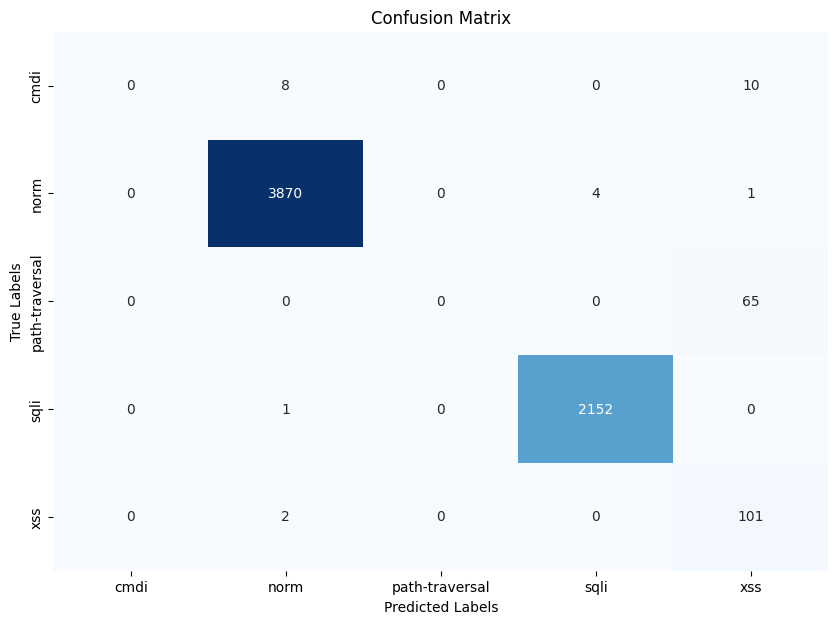

In [49]:
import numpy as np
import seaborn as sns
# Vẽ biểu đồ
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['cmdi', 'norm', 'path-traversal', 'sqli', 'xss'],
            yticklabels=['cmdi', 'norm', 'path-traversal', 'sqli', 'xss'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [27]:
model.save("mlp_detection.h5")

In [28]:
print("Class labels:", label_binarizer.classes_)

Class labels: ['anom' 'norm']


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load
dump(vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']